In [1]:
#import necessary modules, set up the plotting
import numpy as np
import matplotlib 
from scipy import integrate
from matplotlib import pyplot as plt 
plt.style.use('ggplot')
import GPy

$$ \Large f(x) = e^{\sin^2(3x) - x^2} $$ 

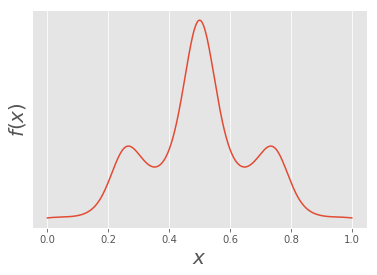

In [2]:
dom = np.linspace(0,1,500).reshape(-1,1)
f = lambda x: (np.e**(-np.sin(3*(4*x-2))**2 - (4*x-2)**2)).flatten()

plt.plot(dom, f(dom))
plt.yticks([])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$f(x)$", fontsize=20)
plt.savefig('fx.png', bbox_inches='tight', dpi=1000)
plt.show()

In [3]:
F = integrate.quad(f, 0, 1)[0]
F

0.28410076748339264

# Compute 

$$ \Large F = \int_0^1 e^{\sin^2(3x) - x^2} dx$$ 


# 1 - Random Sampling

In [5]:
def FUnifSample(X): 
    fUnif = f(X)
    gUnif = 1
    Z = 1
    
    FUnif = Z*np.mean(fUnif/gUnif)
    return(FUnif, X, fUnif)

In [6]:
g = lambda x: (np.e**(- 16*((x-0.5))**2)).flatten()

def FGaussSample(X):
    fGauss = f(X)
    gGauss = g(X)
    
    Z = np.sqrt(2*np.pi*1/32)
    FGauss = Z*np.mean(fGauss/gGauss)
    return(FGauss, X, fGauss)    

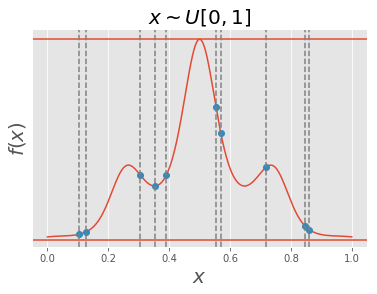

In [13]:
N = 10
X = np.random.uniform(0, 1, size=(N,1))
[FUnif, X, fUnif] = FUnifSample(X)

plt.plot(dom, f(dom))
plt.plot(X, fUnif, 'o')
plt.axhline(y=1)
plt.axhline(y=0)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$f(x)$", fontsize=20)
plt.yticks([])
plt.title('$x \sim U[0, 1]$', fontsize=20)

for x in X:
    plt.axvline(x, color='gray', linestyle='--')


plt.savefig('UnifF.png', bbox_inches='tight', dpi=1000)
plt.show()

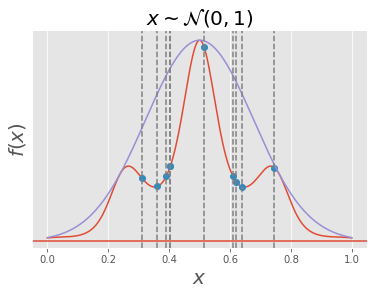

In [12]:
N = 10
X = np.random.normal(0.5, np.sqrt(1/32), size=(N,1))
[FUnif, X, fUnif] = FGaussSample(X)

plt.plot(dom, f(dom))
plt.plot(X, fUnif, 'o')
plt.plot(dom, g(dom))
plt.axhline(y=0)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$f(x)$", fontsize=20)
plt.yticks([])
plt.title('$x \sim \mathcal{N}(0, 1)$', fontsize=20)

for x in X:
    plt.axvline(x, color='gray', linestyle='--')

plt.savefig('GaussF.png', bbox_inches='tight', dpi=1000)
plt.show()

In [13]:
NSim = 100
ConvUnif = np.zeros(NSim)
ConvGauss = np.zeros(NSim)
XUnif = np.zeros(NSim)
XGauss = np.zeros(NSim)

for i in range(NSim):
        XUnif[i] = np.random.uniform(0, 1, size=(1,1))
        XGauss[i] = np.random.normal(0.5, np.sqrt(1/32), size=(1,1))
        [FUnif, XUnif, fUnif] = FUnifSample(XUnif)
        [FGauss, XGauss, fGauss] = FGaussSample(XGauss)
        
        ConvUnif[i] = FUnif
        ConvGauss[i] = FGauss

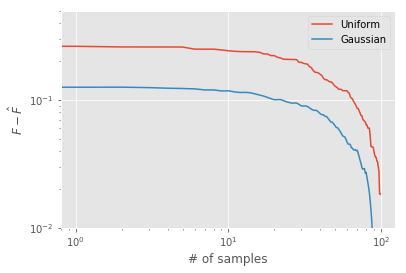

In [14]:
plt.plot(np.abs(F - ConvUnif), label="Uniform")
plt.plot(np.abs(F - ConvGauss), label="Gaussian")
plt.ylim(0.01,0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("# of samples")
plt.ylabel("$F - \hat{F}$")
plt.legend()
plt.show()

# 2- Gaussian Integration
## Idea:

$$ \Large f \sim \mathcal{GP}\left(f; \ 0, \ k(x,x') \right)$$

## Then,

$$ \Large F \sim \mathcal{N}\left(F; \ 0, \ \int \int_0^1 k(s,t) ds dt \right)$$

## and 

$$ 
\Large \begin{bmatrix} F \\ f(x) \end{bmatrix} \sim \mathcal{N}\left(
    \begin{bmatrix} F \\ f(x) \end{bmatrix}; \ 
    \begin{bmatrix} 0 \\ 0 \end{bmatrix}, 
    \ \begin{bmatrix} \int \int_0^1 k(s,t) ds dt & \int_0^1 k(x,t) dt \\ \int_0^1 k(t,x) dt & k(x,x) \end{bmatrix}  \right)
$$

## For a Linear Spline Kernel

$$ \Large k(x,x') = c(1 + b - 2b|x-x'|)$$

## we have

$$ \Large k_{\int}(x) = c\left(1 + b - b(x^2 + (1 - x)^2))\right)$$

## and

$$ \Large k_{\int \int} = c(1 + b/3)$$

In [15]:
def kLS(d,c,b):
    # Linear spline kernel:
    # inputs: 
    #       d: vector of distances
    #       b: weight parameter ~ location of discontinuities, 
    #          small b, few discontinuities. 
    #       c: scale parameter. 
    return(c*(1 + b - 2*b*np.abs(d)))

def kLS_int(x,c,b):
    return( c*((1 + b) - b*(x**2 + (1 - x)**2)) )

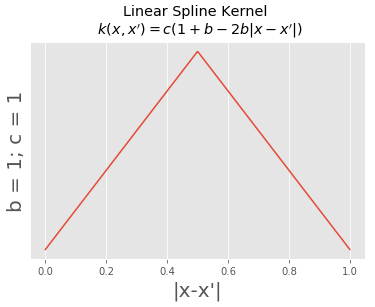

In [23]:
dom = np.linspace(0,1,500).reshape(-1,1)
d = dom - 0.5
kls_dom = kLS(d, 1, 1).flatten()

plt.plot(dom, kls_dom)
plt.title("Linear Spline Kernel \n $k(x,x') = c(1 + b - 2b|x- x'|)$")
plt.xlabel("|x-x'|", fontsize=20)
plt.ylabel("b = 1; c = 1", fontsize=20)
plt.yticks([])
plt.savefig('LSKern.png', bbox_inches='tight', dpi=1000)
plt.show()

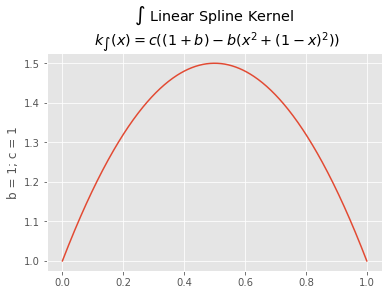

In [18]:
kint_dom = kLS_int(dom, 1, 1).flatten()
plt.plot(dom, kint_dom)
plt.title("$\int$ Linear Spline Kernel \n $k_{\int}(x) = c((1 + b) - b(x^2 + (1 - x)^2))$")
plt.ylabel("b = 1; c = 1")
plt.show()

In [19]:
def PDist(x):  
    # Pairwise distance matrix
    # input: x vector of locations
    
    X = np.kron(x, np.ones(x.size))
    D = X - X.T
    return(D)

In [20]:
def KMat(x, k, params):
    # ourput: K: Covariance mat. 
    # inputs: x vector of locations
    #         k(x, params): kernel
    #         params: n-tuple containing k params.

    D = PDist(x)
    kvect = np.vectorize(k)
    # https://stackoverflow.com/questions/6289646/python-function-as-a-function-argument
    K = kvect(D, *params)
    return(K)

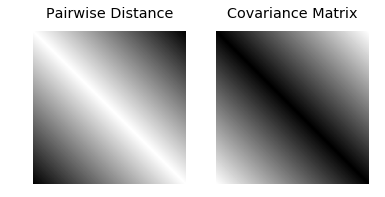

In [21]:
D = PDist(dom)
# get sigma^2 = 1/4
#   var(f(x)) = c(1+b), b = 1 and c = 1/8 
# OR try a small b, like b = 1/100.Then, c = 50/101. The variance is (50*301)/(101*301) ~ 1/3

c = 50/101 # 1/8
b = 1/100 #1
KLS = KMat(dom, kLS, (c, b))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.matshow(np.abs(D), cmap=plt.cm.binary)
ax1.set_title("Pairwise Distance")
ax1.axis('off') # no ticks
ax2.matshow(KLS, cmap=plt.cm.binary)
ax2.set_title("Covariance Matrix")
ax2.axis('off') # no ticks in ax2.
plt.show()

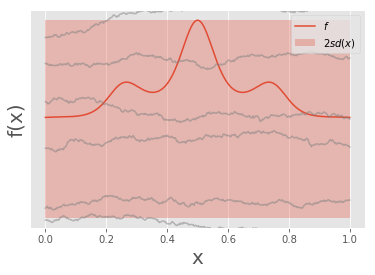

In [29]:
fx = np.random.multivariate_normal(np.zeros(dom.size), KLS, 7)

plt.plot(dom, f(dom), label ="$f$")
for i in range(fx.shape[0]):
    plt.plot(dom, fx[i,:], color="gray", alpha = 0.5)
plt.ylim(-1.1,1.1)
plt.fill_between(dom.flatten(), -1, 1, alpha = 0.3, label = "$2sd(x)$")
plt.legend()
plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.yticks([])
plt.savefig('samples.png', bbox_inches='tight', dpi=1000)
plt.show()

## Use the posterior distribution

$$ 
\Large  F \mid f(x)  \sim \mathcal{N}\left( F \mid f(x); \ m_{F \mid f(x)}\left(x, f(x)\right),\ k_{F \mid f(x)}(x) \right)
$$


## where

$$\Large m_{F \mid f(x)}\left(x, f(x)\right) := k_{\int}(x) k(x,x)^{-1} f(x) $$ 

$$\Large k_{F \mid f(x)}(x) := k_{\int \int} - k_{\int}(x) k(x,x)^{-1} k_{\int}(x) $$ 

## to device a probabilistic integration by minimizing the posterior variance. 

$$ \Large
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{maximize}}
& & k_{F \mid f(x)}(x) \\
\end{aligned}
\end{equation*}
$$

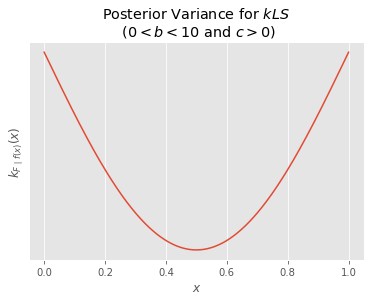

In [30]:
# posterior variance plot in function of b and c. 

def posVarLS(c,b,x):
    y = c*(1+b/3) - ( c*(1+b-b*(x**2 + (1-x)**2)) )**2/(c*(1+b))
    return(y)


c = 1/8 #50/101 
b = 1 #1/100
y = posVarLS(c,b,dom)

plt.plot(dom, y)
plt.title("Posterior Variance for $kLS$ \n ($0 < b < 10$ and $c>0$)")
plt.xlabel("$x$")
plt.ylabel("$k_{F \mid f(x)}(x)$")
plt.yticks([])
plt.show()

## The variance is maximal at $x = 0$ and $x = 1$. Lets condition on $f(1)$:

In [31]:
def GPpost(X, fX, k, params):
    # Computes the posterior distribution of a GP(0,k) given (X, f(X))
    #
    # inputs: (X, fX): observations 
    #         k(d, params): kernel
    #         params: kernel params.
    # outputs: mPost(): posterior mean function. 
    #          vPost(): posterior variance function.
    
    KXX = KMat(X, k, params)
    
    # Inverse covariance matrix
    N = KXX.shape[0]
    s = 0.000005 # noise variance.
    IKXX = np.linalg.inv(KXX + s*np.eye(N))
    
    def mPost(xnew):
        d = X - xnew 
        fxnew = k(d, *params).T.dot(IKXX).dot(fX)
        return(fxnew)
    
    def vPost(x1new, x2new):
        d1 = X - x1new
        d2 = X - x2new
        vfxnew = k(x1new - x2new,*params) - k(d1, *params).T.dot(IKXX).dot(k(d2, *params))
        return(vfxnew)
        
    return(KXX, IKXX, mPost, vPost)

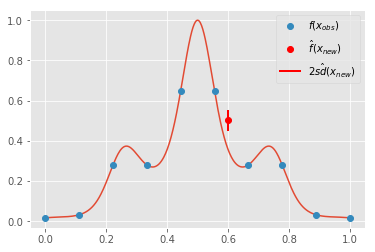

In [49]:
x = np.linspace(0,1,10).reshape(-1,1)
# xnew = np.linspace(0,1,100).reshape(-1,1)
y = f(x)

c = 50/101 # 1/8
b = 1/100 #1
xnew = 0.60

(KXX, IKXX, mPost, vPost) = GPpost(x, y, kLS, (c, b))

plt.plot(dom, f(dom))
plt.plot(x, f(x), 'o', label="$f(x_{obs})$")
plt.plot(xnew , mPost(xnew), 'r.', markersize=12, label="$\hat f(x_{new})$")
v1 = mPost(xnew) - 2*np.sqrt(vPost(xnew, xnew))
v2 = mPost(xnew) + 2*np.sqrt(vPost(xnew, xnew))
plt.plot([xnew, xnew], [v1.flatten(), v2.flatten()], 'r-', lw=2, label="$2 \hat{sd}(x_{new})$")
plt.legend()
plt.show()


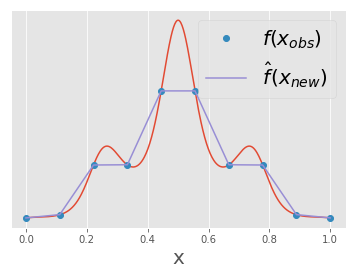

In [60]:
xnew = np.linspace(0,1,100).reshape(-1,1)
mPostV = np.zeros(xnew.size)
for i in range(xnew.shape[0]):
    mPostV[i] = mPost(xnew[i])

plt.plot(dom, f(dom))
plt.plot(x, f(x), 'o', label="$f(x_{obs})$")
plt.plot(xnew , mPostV, '-', markersize=12, label="$\hat f(x_{new})$")
plt.legend(fontsize=20)
plt.yticks([])
plt.xlabel('x', fontsize=20)
plt.savefig('postMean.png', bbox_inches='tight', dpi=1000)
plt.show()

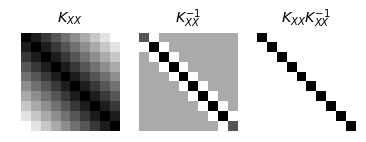

det(KXX(KXX)^{-1})= 0.960043751275


In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
ax1.matshow(KXX, cmap=plt.cm.binary)
ax1.set_title("$K_{XX}$")
ax1.axis('off') # no ticks
ax2.matshow(IKXX, cmap=plt.cm.binary)
ax2.set_title("$K_{XX}^{-1}$")
ax2.axis('off') # no ticks in ax2.
ax3.matshow(KXX.dot(IKXX), cmap=plt.cm.binary)
ax3.axis('off')
ax3.set_title("$K_{XX} K_{XX}^{-1}$")
plt.show()

print("det(KXX(KXX)^{-1})=", np.linalg.det(KXX.dot(IKXX)))

In [34]:
def GPpostSample(nsample, xsample, mPost, vPost):
    
    mPostV = np.vectorize(mPost)
    m = mPostV(xsample).flatten()
    
    N = xsample.size
    cU = np.zeros((N, N))
    v = np.zeros((N, 1))
    for i in range(N):
        for j in range(i, N):
            cU[i, j] = vPost(xsample[i], xsample[j])
    
    c = cU + np.triu(cU, k=1).T 
    
    fx = np.random.multivariate_normal(m, c, nsample)
    
    return(m, c, fx)
    

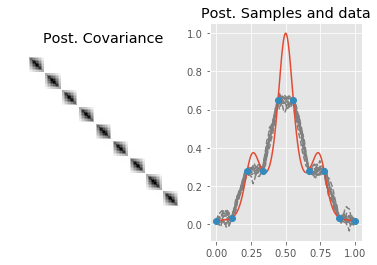

In [35]:
xsample = np.linspace(0,1,100).reshape(-1,1)
nsample = 10

(m, c, fx) = GPpostSample(nsample, xsample, mPost, vPost)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.matshow(c, cmap=plt.cm.binary)
ax1.set_title("Post. Covariance")
ax1.axis('off') # no ticks
for i in range(fx.shape[0]):
    ax2.plot(xsample, fx[i, :], '--', color="gray")
ax2.plot(dom, f(dom))
ax2.plot(x, y, 'o')
ax2.set_title("Post. Samples and data")
plt.show()

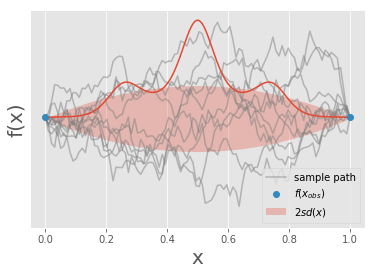

In [46]:
x = np.linspace(0,1,2).reshape(-1,1)
y = f(x)

c = 1/3 #50/101 #1/8
b = 1/2 #1/100 #1
xnew = 0.60

(KXX, IKXX, mPost, vPost) = GPpost(x, y, kLS, (c, b))

xsample = np.linspace(0,1,100).reshape(-1,1)
nsample = 10

(m, C, fx) = GPpostSample(nsample, xsample, mPost, vPost)
v = np.diag(C)

plt.plot(xsample, fx[0, :], color="gray", label="sample path", alpha = 0.5)
for i in range(1, fx.shape[0]):
    plt.plot(xsample, fx[i, :], color="gray", alpha = 0.5)
plt.plot(dom, f(dom))
plt.plot(x, y, 'o', label="$f(x_{obs})$")
plt.fill_between(xsample.flatten(), -2*v, 2*v, alpha = 0.3, label = "$2sd(x)$")
plt.ylim(-1.1,1.1)
plt.legend(loc=4)
plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.yticks([])
plt.savefig('PosteriorSamples2.png', bbox_inches='tight', dpi=1000)
plt.show()

In [39]:
def GPintegration(x, k, kS, kSS, params):
    
    # posterior distribution of F | f(t_1), ..., f(t_nx).
    # inputs: x: 
    #         k(d, params): kernel of f. 
    #         kS(d, params): Cov(f, \int f(t) dt)
    #         kSS(d, params):kernel of \int f(t) dt
    # 
    # outputs: add this output?? m: posterior mean m_{F|f}(x, f(x))
    #          v: posterior variance k_{F|f}(x) evaluated at x. 
    #          Kxx, IKxx: covariance matrix of f and its inverse.
    
    nx = x.shape[0]
    Kxx = KMat(x, k, params)
    IKxx = np.linalg.inv(Kxx + c*np.eye(nx))
    
    kSVect = np.vectorize(kS)
    kSx = kSVect(x, *params)
    
    v = kSS - kSx.T.dot(IKxx).dot(kSx)
    
    return(v, Kxx, IKxx)
    
    

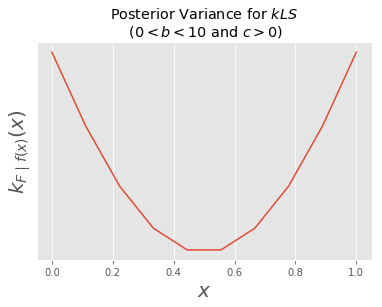

In [40]:
x = np.linspace(0,1,10).reshape(-1,1)
k = kLS
kS = kLS_int
kSS = c*(1+b) 

# Posterior 1d variacne. 
V = np.zeros(x.size)

for i in range(x.size):
    (v, Kxx, IKxx) = GPintegration(x[i], k, kS, kSS, (c, b))
    V[i] = v

    
plt.plot(x, V)
plt.title("Posterior Variance for $kLS$ \n ($0 < b < 10$ and $c>0$)")
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$k_{F \mid f(x)}(x)$", fontsize=20)
plt.yticks([])
#plt.savefig('PosteriorVariance1d.png', bbox_inches='tight', dpi=1000)
plt.show()

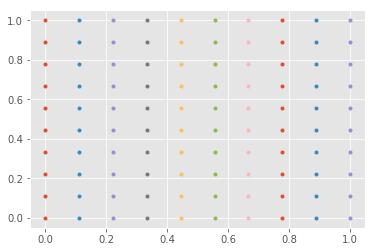

100

In [41]:
x1, x2 = np.meshgrid(x, x)

X12 = np.column_stack((x1.flatten(), x2.flatten()))

plt.plot(x1, x2, '.')
plt.show()

X12.shape[0]

In [42]:
V = np.zeros((X12.shape[0], 1))
for i in range(X12.shape[0]):
    (v, Kxx, IKxx) = GPintegration(X12[i,:].reshape(-1,1), k, kS, kSS, (c, b))
    V[i] = v

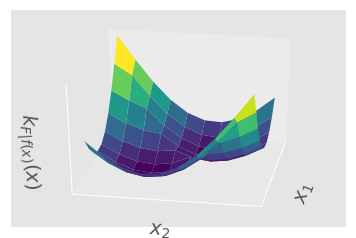

In [48]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Vmat = V.reshape(x1.shape)
surf = ax.plot_surface(x1, x2, Vmat, cmap=plt.cm.viridis)
ax.view_init(30, 10)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_zlabel('$k_{F|f(x)}(x)$', fontsize=20)
#ax.set_title('Posterior Variance for $kLS$ \n ($0 < b < 10$ and $c>0$)')
plt.savefig('PosteriorVariance2d.png', bbox_inches='tight', dpi=1000)
plt.show()
